[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gomar0801/BachGen/blob/main/notebooks/Pipeline.ipynb)

In [1]:
%%capture
# Clone the BachGen repository
!rm -rf BachGen && git clone https://github.com/gomar0801/BachGen.git
!chmod +x ./BachGen/scripts/setup.sh
!./BachGen/scripts/setup.sh

In [2]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 78.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.2 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=63056404a250bbaa6f47bc714959e8f3ac80bc7ec440f970a65c108ae84d39a1
  Stored in directory: /root/.cache/pip/wheels/a4/f9/9e/08350c27e386558df0ae234e28a8facd145ba45506ddd1b989
Successfully built pretty_midi


In [3]:
from bachgen.download_data import download_all
from bachgen.extract import extract_archive
from bachgen.data_filter import load_and_filter_piano_classical
from bachgen.mxl_to_musicxml import convert_mxl_to_musicxml
from bachgen.batch_convert_mxl_to_musicxml import convert_many_mxl_to_musicxml
from bachgen.display_and_play_partition import display_and_play
from bachgen.score_to_tokens_simplify import MusicXML_to_tokens
from bachgen.batch_tokenize_with_stats import tokenize_folder_with_stats
from bachgen.tokens_to_musicxml import convert_tokens_to_musicxml
from bachgen.vocab_utils import load_vocab, decode_ids_file
from bachgen.vocab_pipeline import build_and_encode

# Telechargement des données

In [6]:
download_all()

⬇️  Téléchargement depuis https://zenodo.org/records/15571083/files/mxl.tar.gz?download=1 ...
✅ Fichier téléchargé : data/mxl.tar.gz
⬇️  Téléchargement depuis https://zenodo.org/records/15571083/files/PDMX.csv?download=1 ...
✅ Fichier téléchargé : data/PDMX.csv


In [7]:
extract_folder=extract_archive("/content/data/mxl.tar.gz")

📦 Extraction de /content/data/mxl.tar.gz vers data/mxl ...
✅ Extraction terminée dans : data/mxl


# Filtrage

In [8]:
df_piano_classical = load_and_filter_piano_classical()

🎹 24008 partitions de piano (genre classique) trouvées.


# MXL to MusicXML

In [9]:
MXL_ROOT = "data/mxl"
OUT_DIR  = "data/musicxml_classical_piano_convert"

done, errors = convert_many_mxl_to_musicxml(
    items=df_piano_classical,           # DataFrame filtré : df_piano_classical
    mxl_root=MXL_ROOT,
    out_dir=OUT_DIR,
    path_col="mxl",                     # adapte si ta colonne s'appelle autrement
    timeout=10,
    max_workers=1,                      # music21 est peu thread-safe → rester bas
    resume=True,
    error_log_csv="data/convert_errors.csv",
)

Converting: 100%|██████████| 24004/24004 [4:29:00<00:00,  1.49it/s]

✅ Conversion terminée: 23806 fichiers créés dans data/musicxml_classical_piano_convert
⚠️ 198 problème(s). Exemples:
  - ('data/mxl/mxl/1/40/QmbrSSE9PT79WZvdB4yQv5149fTcs3yuzSeRVm3yYmy1Wh.mxl', 'the object (<music21.stream.Measure 17 offset=48.0>, id()=136355895096240 is already found in this Stream (<music21.stream.Part Soprano Alto>, id()=136355714980016)')
  - ('data/mxl/mxl/1/51/QmbWzooTBsuRDYQMQ4VAiaC9NyazN4sM6i4YBq3a8Gb83s.mxl', 'the object (<music21.stream.Measure 34 offset=64.5>, id()=136355646625632 is already found in this Stream (<music21.stream.Part Piano>, id()=136355916216032)')
  - ('data/mxl/mxl/1/23/QmbhFfCTvxiJi6TgGaY5MpFTnd1hD9fhFxAzP8Gtfe1jym.mxl', 'the object (<music21.stream.Measure 19 offset=54.0>, id()=136355912896720 is already found in this Stream (<music21.stream.Part Staff>, id()=136355623615952)')
  - ('data/mxl/mxl/1/8/Qmb99NMtky28eyP1NpRQwS5dhHFM2VrhZNA8JBgWhdLP76.mxl', 'the object (<music21.stream.Measure 12 offset=42.0>, id()=136355916212528 is already 

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Pensez à sauvegarder pour ne pas tout relancer à chaque fois
!cp -r /content/data/musicxml_classical_piano_convert /content/drive/MyDrive/Stage\ MusicXML/musicxml_classical_piano_convert_100%     #à adapter

# MusicXML to Tokens (+statistics)

## Sans statistique

In [ ]:
from pathlib import Path

SRC_DIR = Path("data/musicxml_classical_piano")  # dossier avec les .musicxml
OUT_DIR = Path("data/tokens_classical_piano")
OUT_DIR.mkdir(parents=True, exist_ok=True)

for xml_file in SRC_DIR.glob("*.musicxml"):
    try:
        tokens = MusicXML_to_tokens(str(xml_file))
        out_file = OUT_DIR / (xml_file.stem + ".txt")
        with open(out_file, "w", encoding="utf-8") as f:
            f.write(" ".join(tokens))
        print(f"✅ {xml_file.name} → {out_file.name}")
    except Exception as e:
        print(f"❌ {xml_file.name} -> {e}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  → Backup : -40320
    • Note: Rest, Voice: 2, Start: 0, Duration: 30240, Chord: False
    • Note: G4, Voice: 2, Start: 30240, Duration: 10080, Chord: False
[Résultat] 10 notes extraites avec positions.


  → 10 notes extraites avec positions
  → Notes triées par position :
    • Pos     0, Voice 1, Note: G4
    • Pos     0, Voice 1, Note: D5
    • Pos     0, Voice 2, Note: Rest
    • Pos 10080, Voice 1, Note: A4
    • Pos 10080, Voice 1, Note: D5
    • Pos 20160, Voice 1, Note: G4
    • Pos 20160, Voice 1, Note: D5
    • Pos 30240, Voice 1, Note: C5
    • Pos 30240, Voice 2, Note: G4
    • Pos 35280, Voice 1, Note: D5

  → Position 0 : 3 élément(s)
    ⚠ Silences superposés détectés, ils sont ignorés.
    ↳ Durée harmonisée de l'accord : 10080

  → Position 10080 : 2 élément(s)
    ↳ Durée harmonisée de l'accord : 10080

  → Position 20160 : 2 élément(s)
    ↳ Durée harmonisée de l'accord : 10080

  → Posit

KeyboardInterrupt: 

## Avec Statistiques

In [ ]:
!cp -r /content/drive/MyDrive/Stage\ MusicXML/musicxml_classical_piano_convert  /content/data

In [17]:
from pathlib import Path

SRC_DIR = Path("/content/data/musicxml_classical_piano_convert")
TOK_DIR = Path("data/tokens_classical_piano_simplify")
STATS_CSV = Path("data/tokenization_stats_V2.csv")

_ = tokenize_folder_with_stats(
    src_dir=SRC_DIR,
    out_tok_dir=TOK_DIR,
    stats_csv=STATS_CSV,
    note_name=True,
    pattern="*.musicxml",
    resume=True,
    verbose=True,
)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
✅ Qmc1EfZpt1yffGHqEgjZyPg4EgvTZHpjBdVpTLxA8s7mrR.musicxml  [transp 0.526% | overl.rest 1.316% | harmo 4.211% (count=16)]
✅ Qmc1Es8xdB69pWzmedE2Gmb5eUvZ2e59cyV2boPRRTZVta.musicxml  [transp 0.0% | overl.rest 0.503% | harmo 1.508% (count=6)]
✅ Qmc1FV8qWr7u6hLGVeogtNHtvcjVoVtjZRea4umPYu9dEv.musicxml  [transp 0.0% | overl.rest 2.344% | harmo 15.625% (count=20)]
✅ Qmc1HM8Wn94b2BBEU5b3qw11KZ8G5FZ6aEKrhmMhWCuofS.musicxml  [transp 1.325% | overl.rest 8.609% | harmo 20.53% (count=31)]
✅ Qmc1Hx8pXg81uADsxMSnBB4CPN37TBy3P2JiRDMT7Dxpvy.musicxml  [transp 2.575% | overl.rest 7.725% | harmo 31.33% (count=73)]
✅ Qmc1LppixQyuSDLo5s4eW3ot8SCxbpLsSxY1MJHvdvhRsS.musicxml  [transp 1.55% | overl.rest 6.977% | harmo 24.031% (count=31)]
✅ Qmc1MFuKa9coeWwvwA72zyvqPYzRbUWNQih8eCXQmYpAbT.musicxml  [transp 0.0% | overl.rest 10.0% | harmo 40.0% (count=52)]
✅ Qmc1Npaj2BhHu2cWj7psNTFhQw1t4E1J8AX9Erp3dWzHGi.musicxml  [transp 3.472% | overl.r

In [18]:
!cp -r /content/data/tokens_classical_piano_simplify /content/drive/MyDrive/Stage\ MusicXML/tokens_classical_piano_simplify_100%

In [20]:
!cp -r /content/data/tokenization_stats_V2.csv /content/drive/MyDrive/Stage\ MusicXML/tokenization_stats_V2.csv

Resumé du tableau de statistique :    
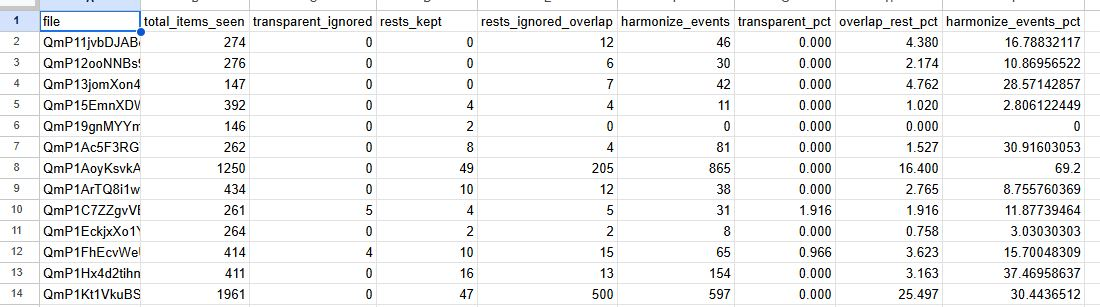
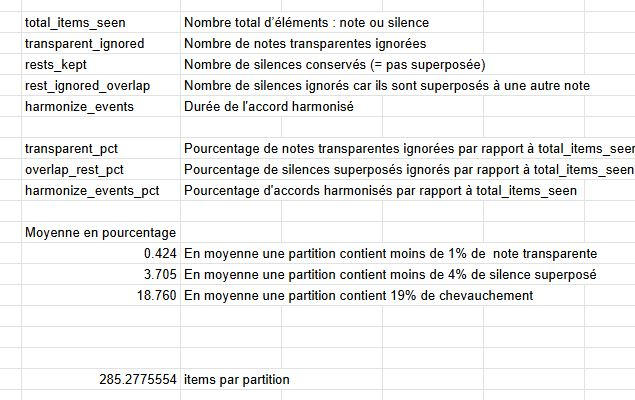

# Construction dictionaire tokens<->id

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!cp -r /content/drive/MyDrive/Stage\ MusicXML/tokens_classical_piano_simplify_100%/. /content/data/tokens_classical_piano_simplify_100%/

In [15]:
from pathlib import Path

TOK_DIR   = Path("/content/data/tokens_classical_piano_simplify_100%")
IDS_DIR   = Path("data/token_ids_simplify_100%")
VOCAB_OUT = Path("data/vocab/token2id.json")

# 1) Construire vocab + encoder tous les tokens -> ids
token2id, vocab_size = build_and_encode(
    token_dir=TOK_DIR,
    vocab_out=VOCAB_OUT,
    ids_out_dir=IDS_DIR,
    specials=("[PAD]", "[UNK]", "<BOS>", "<EOS>"),
    min_freq=1,
    pattern="*.txt",
    add_bos=True,
    add_eos=True,
)
print("Vocab size:", vocab_size)

# 2) Recharger plus tard le vocab (si nécessaire)
token2id, id2token = load_vocab(VOCAB_OUT)

Vocab size: 364


'\n# 3) Décoder un fichier d\'IDs pour contrôle rapide\nsome_ids = next(IDS_DIR.glob("*.ids.txt"))\ndecoded = decode_ids_file(some_ids, VOCAB_OUT, join_tokens=True)\nprint(decoded[:200], "...")\n'

In [17]:
print(token2id)

{'[PAD]': 0, '[UNK]': 1, '<BOS>': 2, '<EOS>': 3, 'len_1': 4, 'len_1/2': 5, 'bar': 6, 'note_D4': 7, 'len_1/4': 8, 'note_G4': 9, 'note_C4': 10, 'note_F4': 11, 'note_G3': 12, 'len_2': 13, 'note_A4': 14, 'note_E4': 15, 'note_A3': 16, 'note_Eb4': 17, 'note_Bb3': 18, 'note_C5': 19, 'note_F3': 20, 'rest': 21, 'note_D3': 22, 'note_Bb4': 23, 'note_D5': 24, 'note_C3': 25, 'len_3/2': 26, 'note_B3': 27, 'note_B4': 28, 'note_Eb3': 29, 'note_Ab3': 30, 'note_F#4': 31, 'len_3/4': 32, 'note_Bb2': 33, 'note_E3': 34, 'note_Ab4': 35, 'len_3': 36, 'note_A2': 37, 'note_E5': 38, 'note_C#4': 39, 'note_F#3': 40, 'note_G2': 41, 'note_Db4': 42, 'len_1/3': 43, 'note_Ab2': 44, 'len_4': 45, 'note_C#5': 46, 'note_B2': 47, 'note_Eb5': 48, 'note_F5': 49, 'note_G#4': 50, 'note_Db3': 51, 'note_G5': 52, 'clef_treble': 53, 'note_G#3': 54, 'clef_bass': 55, 'time_4/4': 56, 'note_A5': 57, 'note_Db5': 58, 'L': 59, 'R': 60, 'note_F#5': 61, 'note_F2': 62, 'note_D#4': 63, 'note_C#3': 64, 'note_Gb4': 65, 'len_1/8': 66, 'len_1/6':

In [16]:

# 3) Décoder un fichier d'IDs pour contrôle rapide
some_ids = next(IDS_DIR.glob("*.ids.txt"))
decoded = decode_ids_file(some_ids, VOCAB_OUT, join_tokens=True)
print(decoded[:200], "...")


<BOS> R bar key_natural_0 time_4/4 clef_treble note_C4 note_G4 len_2 note_C4 note_E4 len_1 note_C4 note_C4 len_1 bar note_C4 note_A4 len_3/2 note_C4 note_G4 len_1/2 note_C4 note_G4 len_2 bar note_C4 n ...


In [18]:
!cp -r /content/data/token_ids_simplify_100% /content/drive/MyDrive/Stage\ MusicXML/

In [28]:
!cp -r /content/data/vocab_100% /content/drive/MyDrive/Stage\ MusicXML/

# Training (Model GPT2 from scratch)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!cp -r /content/drive/MyDrive/Stage\ MusicXML/token_ids_simplify_100% /content/data/token_ids_simplify/

In [8]:
!cp -r /content/drive/MyDrive/Stage\ MusicXML/vocab_100%/. /content/data/vocab/

In [9]:
from transformers import GPT2Config, GPT2LMHeadModel, TrainingArguments, Trainer

In [10]:
from pathlib import Path
from bachgen.training.splits import (
    load_vocab_ids, load_all_ids, split_sequences, save_split, load_split
)
from bachgen.training.train_gpt2 import (
    build_gpt2_config, make_datasets, default_training_args,
    train_gpt2, evaluate, save_model
)

# Paths
VOCAB_PATH  = Path("/content/data/vocab/token2id.json")
IDS_DIR     = Path("/content/data/token_ids_simplify/token_ids_simplify_100%")       # tes .ids.txt
SPLIT_DIR   = Path("data/pretokenized_splits")
SPLIT_DIR.mkdir(parents=True, exist_ok=True)

# 1) Vocab & specials
VOCAB_SIZE, PAD_ID, BOS_ID, EOS_ID = load_vocab_ids(VOCAB_PATH)
print("VOCAB:", VOCAB_SIZE, "PAD/BOS/EOS:", PAD_ID, BOS_ID, EOS_ID)

# 2) Charger toutes les séquences d’IDs & faire les splits
all_sequences = load_all_ids(IDS_DIR, suffix=".txt")   # si tes fichiers finissent par .ids.txt, mets suffix=".ids.txt"
train_seqs, valid_seqs, test_seqs = split_sequences(all_sequences, train_ratio=0.90, valid_ratio=0.05, seed=42)

# (optionnel) Sauvegarder les splits
save_split(train_seqs, SPLIT_DIR / "train_ids.txt")
save_split(valid_seqs, SPLIT_DIR / "valid_ids.txt")
save_split(test_seqs,  SPLIT_DIR / "test_ids.txt")

# 3) Datasets
BLOCK = 1024
train_ds, valid_ds, test_ds = make_datasets(train_seqs, valid_seqs, test_seqs, block_size=BLOCK)

# 4) Config + TrainingArguments + entraînement
config = build_gpt2_config(
    vocab_size=VOCAB_SIZE, pad_id=PAD_ID, bos_id=BOS_ID, eos_id=EOS_ID,
    n_positions=BLOCK, n_embd=1024, n_layer=4, n_head=4
)

targs = default_training_args(out_dir=Path("./gpt2-musicxml-ids"),
                              num_epochs=8, per_device_bs=2, grad_accum=4)

trainer, model = train_gpt2(train_ds, valid_ds, config, targs)

# 5) Évaluations
val_loss, val_ppl = evaluate(trainer, valid_ds)
print("Validation:", val_loss, val_ppl)
test_loss, test_ppl = evaluate(trainer, test_ds)
print("Test:", test_loss, test_ppl)

# 6) Sauvegarde
save_model(trainer, Path("./final_model_gpt2_ids"))

VOCAB: 364 PAD/BOS/EOS: 0 2 3
  -> 10259 chunks de taille 1024 (à partir de 20766 morceaux)
  -> 578 chunks de taille 1024 (à partir de 1153 morceaux)
  -> 547 chunks de taille 1024 (à partir de 1155 morceaux)


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,1.665000,1.646393
2,1.418100,1.326996
3,1.238600,1.151342
4,1.106200,1.043854
5,1.055200,0.983408
6,1.000600,0.933391
7,0.931200,0.899427
8,0.889400,0.885062


Validation: 0.8850619196891785 2.4231344265709702
Test: 0.8746966123580933 2.3981476152383814


In [11]:
save_model(trainer, Path("/content/drive/MyDrive/Stage MusicXML/Models_classical_piano/model_gpt2_ids_V2"))

# Generation

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 1ere Generation

In [16]:
from bachgen.generate import generate_tokens_from_primer
from bachgen.tokens_to_score import tokens_to_score   # ou ta fonction convert_tokens_to_musicxml

MODEL_DIR = "/content/drive/MyDrive/Stage MusicXML/Models_classical_piano/model_gpt2_ids_V2"
VOCAB_PATH = "/content/drive/MyDrive/Stage MusicXML/vocab_100%/token2id.json"

# Génération à partir de BOS uniquement
tokens = generate_tokens_from_primer(
    model_dir=MODEL_DIR,
    vocab_path=VOCAB_PATH,
    primer_tokens=[],              # pas de tokens → juste BOS
    stop_tokens=None,              # on s’arrête uniquement à EOS
    max_new_tokens=300,
    top_k=8,
    temperature=1.0,
)

print("✅ Tokens générés:", tokens[:50], "...")

✅ Tokens générés: ['R', 'bar', 'key_flat_4', 'time_4/4', 'clef_treble', 'note_C5', 'note_Eb4', 'len_1/2', 'note_Db5', 'note_F4', 'len_1/2', 'bar', 'note_C5', 'note_Eb4', 'len_3', 'note_C5', 'note_Eb4', 'len_1/2', 'note_Db5', 'note_F4', 'len_1/2', 'bar', 'note_C5', 'note_Eb4', 'len_3', 'note_Eb4', 'note_C4', 'len_1/2', 'note_Eb4', 'note_C4', 'len_1/2', 'bar', 'note_F4', 'note_Db4', 'len_1', 'note_Ab4', 'note_F4', 'len_1', 'note_F4', 'note_Db4', 'len_2', 'bar', 'note_Ab4', 'note_F4', 'len_1', 'note_F4', 'note_Db4', 'len_1', 'note_Eb4', 'note_C4'] ...


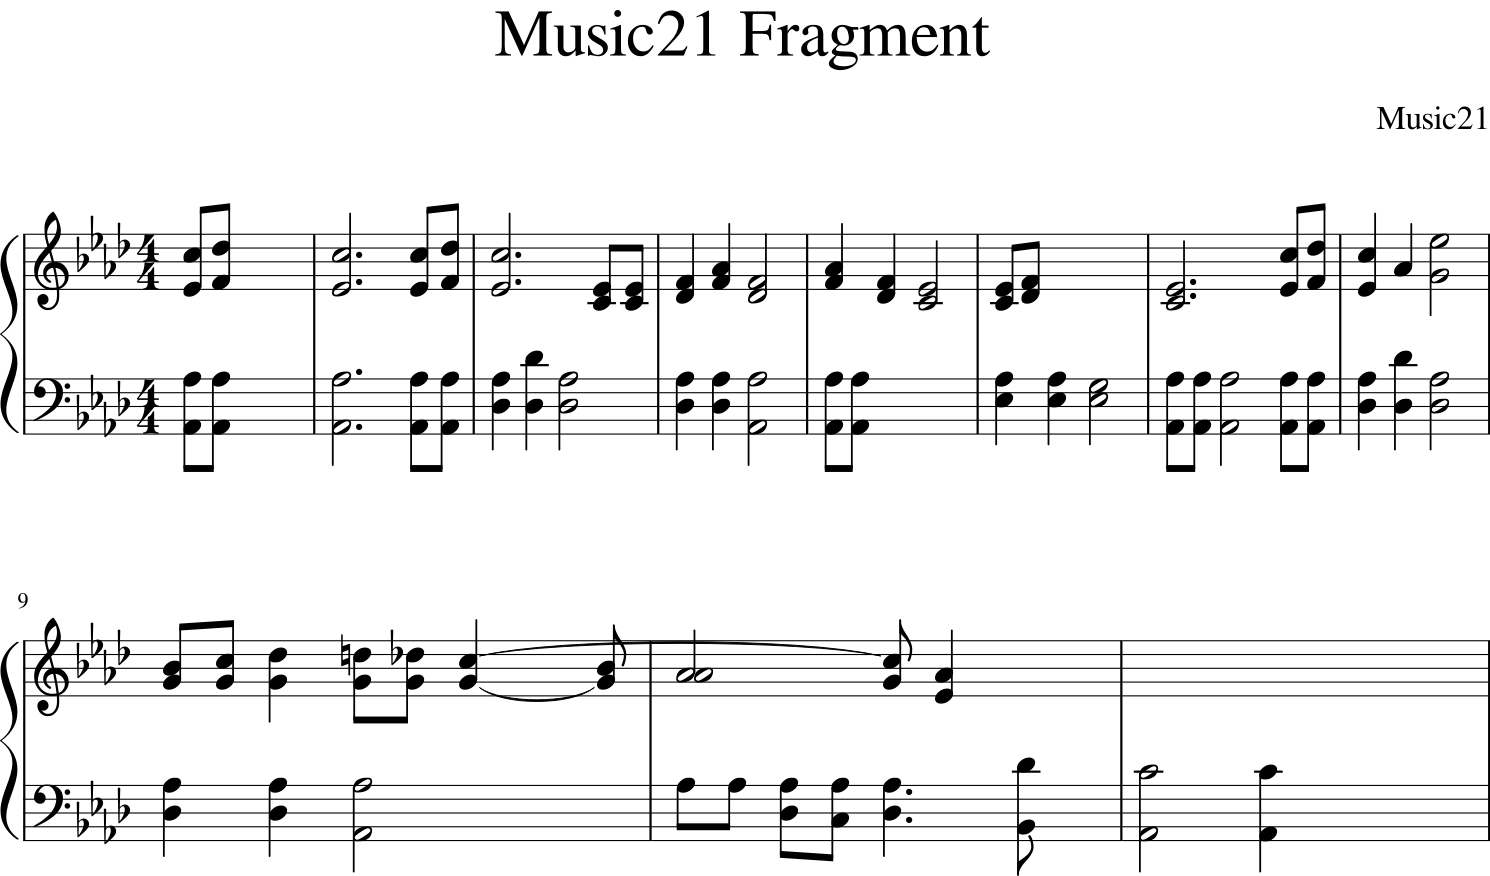

In [17]:
# Conversion en MusicXML + affichage
xml_path = "/content/output.musicxml"
score = convert_tokens_to_musicxml(tokens, xml_path)
display_and_play(xml_path)

#### 2eme Generation

In [18]:
from bachgen.generate import generate_tokens_from_primer

MODEL_DIR = "/content/drive/MyDrive/Stage MusicXML/Models_classical_piano/model_gpt2_ids_V2"
VOCAB_PATH = "/content/drive/MyDrive/Stage MusicXML/vocab_100%/token2id.json"

primer_tokens = ["R", "bar", "key_flat_3", "time_4/4", "clef_treble"]

tokens = generate_tokens_from_primer(
    model_dir=MODEL_DIR,
    vocab_path=VOCAB_PATH,
    primer_tokens=primer_tokens,  # <- ton prompt de départ
    stop_tokens=None,              # s’arrête uniquement sur <EOS>
    max_new_tokens=300,
    top_k=8,
    temperature=1.0,
)

print("✅ Tokens générés (début):", tokens[:50], "...")

✅ Tokens générés (début): ['R', 'bar', 'key_flat_3', 'time_4/4', 'clef_treble', 'note_G4', 'note_G4', 'len_1', 'note_G4', 'len_1', 'note_G4', 'len_1', 'note_G4', 'len_1', 'bar', 'note_G4', 'note_Eb4', 'len_3/4', 'note_G4', 'note_Eb4', 'len_1/4', 'note_G4', 'note_Eb4', 'len_3/4', 'note_Ab4', 'note_F4', 'len_1/4', 'note_Bb4', 'note_G4', 'len_2', 'bar', 'note_G4', 'note_Eb4', 'len_3/4', 'note_F#4', 'note_D4', 'len_1/4', 'note_Ab4', 'note_F4', 'len_3/4', 'note_G4', 'note_Eb4', 'len_1/4', 'note_Ab4', 'note_F4', 'len_1', 'note_G4', 'note_Eb4', 'len_3/4', 'note_F4'] ...


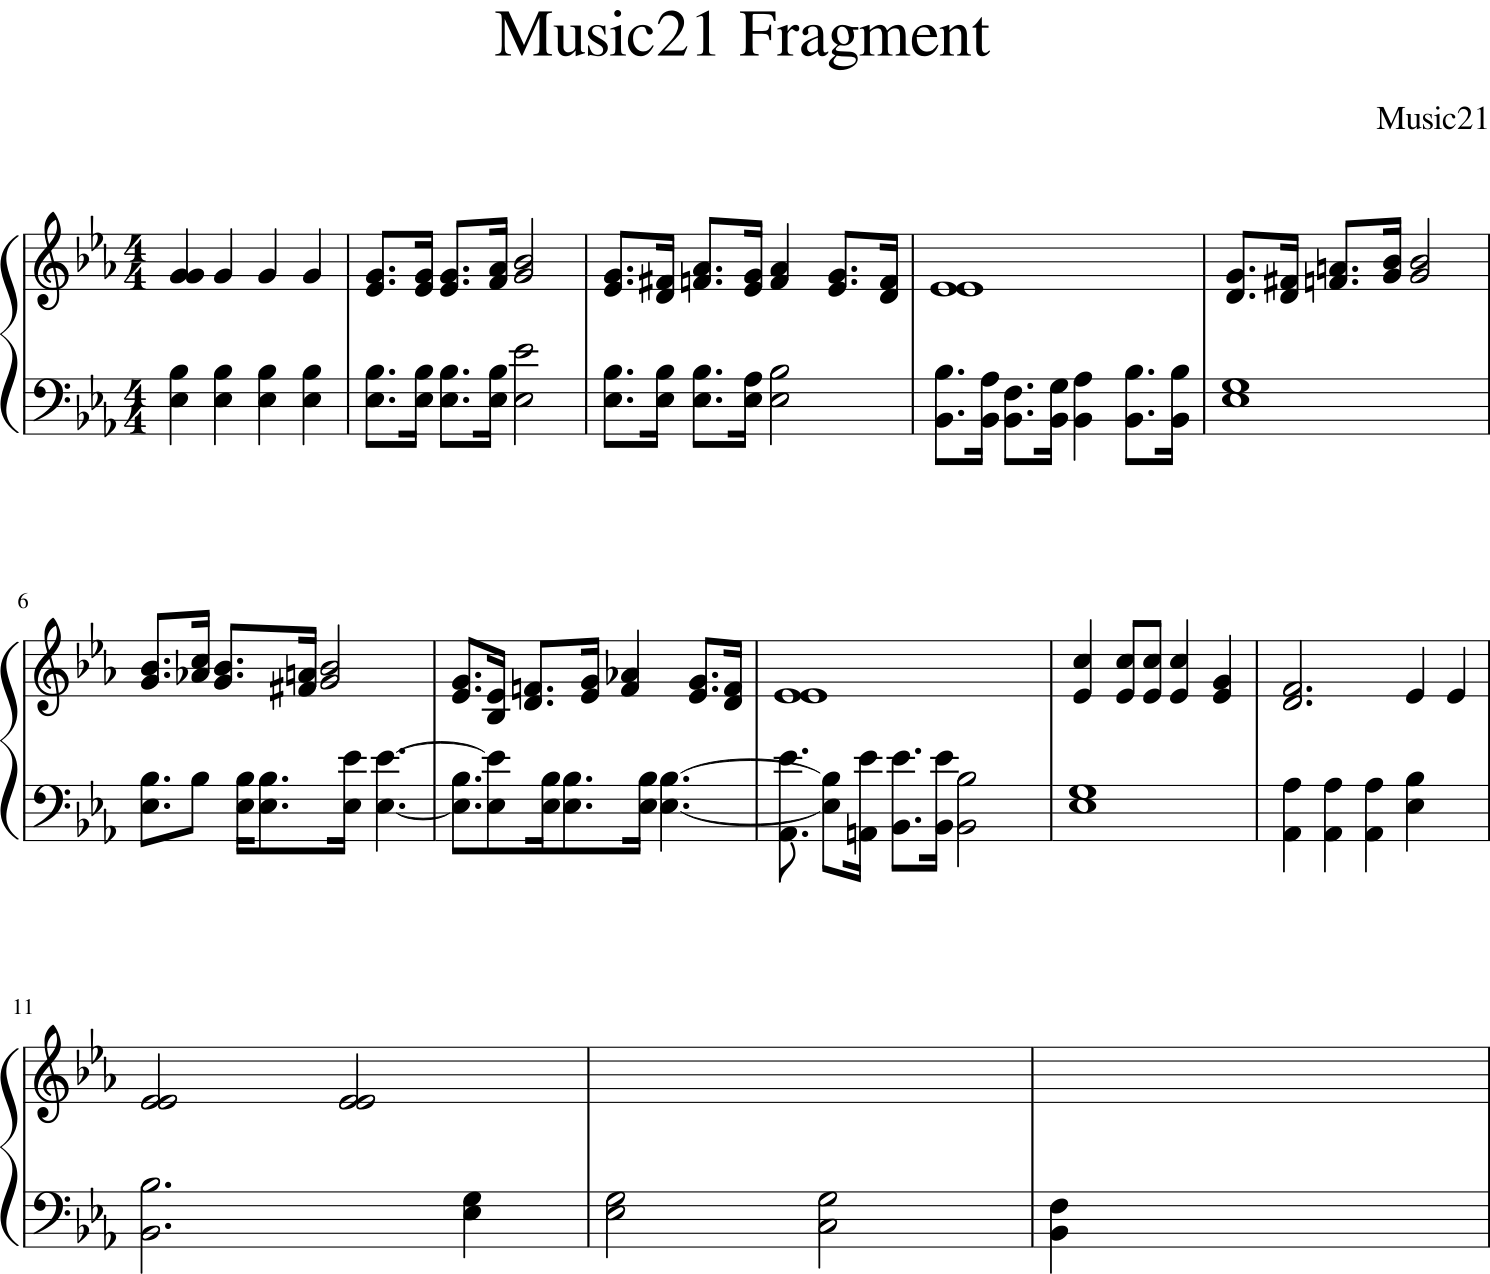

In [19]:
# Conversion en MusicXML + affichage
xml_path = "/content/output.musicxml"
score = convert_tokens_to_musicxml(tokens, xml_path)
display_and_play(xml_path)

#### 3eme Generation

In [20]:
from bachgen.generate import generate_tokens_from_primer

MODEL_DIR = "/content/drive/MyDrive/Stage MusicXML/Models_classical_piano/model_gpt2_ids_V2"
VOCAB_PATH = "/content/drive/MyDrive/Stage MusicXML/vocab_100%/token2id.json"

primer_tokens = ['R', 'bar', 'key_flat_1', 'time_3/4', 'clef_treble',
    'note_C5', 'note_F4', 'len_1', 'note_C5', 'note_F4', 'len_1',
    'note_D5', 'note_F4', 'len_1',
    'bar', 'note_C5', 'note_F4', 'len_1', 'note_A4', 'note_F4', 'len_1',
    'note_G4', 'note_E4', 'len_1',
    'bar', 'note_F4', 'len_1', 'note_G4', 'note_F4', 'len_1',
    'note_G4', 'note_E4', 'len_1',
    'bar', 'note_A4', 'note_F4', 'len_3',
    'bar', 'note_A4', 'note_F4', 'len_1', 'note_G4', 'note_E4', 'len_1',
    'note_F4', 'len_1',
    'bar', 'note_G4', 'note_C5', 'len_1', 'note_E4', 'len_1',
    'rest', 'len_1/2', 'note_Bb4', 'note_A4', 'note_F4', 'len_1/2',
    'bar', 'note_G4', 'note_D4', 'len_1', 'note_A4', 'note_C4', 'len_1',
    'note_A3', 'note_F4', 'len_1/2', 'note_B3', 'len_1/2',
    'bar', 'note_C4', 'note_A4', 'len_1', 'note_G4', 'len_2',
    'bar', 'note_C4', 'len_1', 'note_F4', 'note_C4', 'len_1',
    'note_A4', 'note_C4', 'len_1',
    'bar', 'note_C5', 'note_C4', 'len_1', 'note_A4', 'note_C4', 'len_1',
    'note_G4', 'note_C4', 'len_1',
    'bar', 'note_F4', 'note_D4', 'len_1', 'note_Bb4', 'note_D4', 'len_1',
    'note_C5', 'note_F4', 'len_1',
    'bar', 'note_D5', 'note_F4', 'len_3',
    'bar', 'note_D5', 'note_F4', 'len_1', 'note_D5', 'note_F4', 'len_1',
    'note_C5', 'note_E4', 'len_1',
    'bar', 'note_F4', 'len_1', 'note_Bb4', 'note_G4', 'len_1',
    'note_A4', 'note_F4', 'len_1',
    'bar', 'note_G4', 'note_D4', 'len_1', 'note_F4', 'note_C4', 'len_1',
    'note_E4', 'note_C4', 'len_1',
    'bar', 'note_F4', 'note_C4', 'len_3',
    'L', 'bar', 'key_flat_1', 'time_3/4', 'clef_bass'
]

tokens = generate_tokens_from_primer(
    model_dir=MODEL_DIR,
    vocab_path=VOCAB_PATH,
    primer_tokens=primer_tokens,  # <- ton prompt de départ
    stop_tokens=None,              # s’arrête uniquement sur <EOS>
    max_new_tokens=300,
    top_k=8,
    temperature=1.0,
)

print("✅ Tokens générés :", tokens)

✅ Tokens générés : ['R', 'bar', 'key_flat_1', 'time_3/4', 'clef_treble', 'note_C5', 'note_F4', 'len_1', 'note_C5', 'note_F4', 'len_1', 'note_D5', 'note_F4', 'len_1', 'bar', 'note_C5', 'note_F4', 'len_1', 'note_A4', 'note_F4', 'len_1', 'note_G4', 'note_E4', 'len_1', 'bar', 'note_F4', 'len_1', 'note_G4', 'note_F4', 'len_1', 'note_G4', 'note_E4', 'len_1', 'bar', 'note_A4', 'note_F4', 'len_3', 'bar', 'note_A4', 'note_F4', 'len_1', 'note_G4', 'note_E4', 'len_1', 'note_F4', 'len_1', 'bar', 'note_G4', 'note_C5', 'len_1', 'note_E4', 'len_1', 'rest', 'len_1/2', 'note_Bb4', 'note_A4', 'note_F4', 'len_1/2', 'bar', 'note_G4', 'note_D4', 'len_1', 'note_A4', 'note_C4', 'len_1', 'note_A3', 'note_F4', 'len_1/2', 'note_B3', 'len_1/2', 'bar', 'note_C4', 'note_A4', 'len_1', 'note_G4', 'len_2', 'bar', 'note_C4', 'len_1', 'note_F4', 'note_C4', 'len_1', 'note_A4', 'note_C4', 'len_1', 'bar', 'note_C5', 'note_C4', 'len_1', 'note_A4', 'note_C4', 'len_1', 'note_G4', 'note_C4', 'len_1', 'bar', 'note_F4', 'note_D

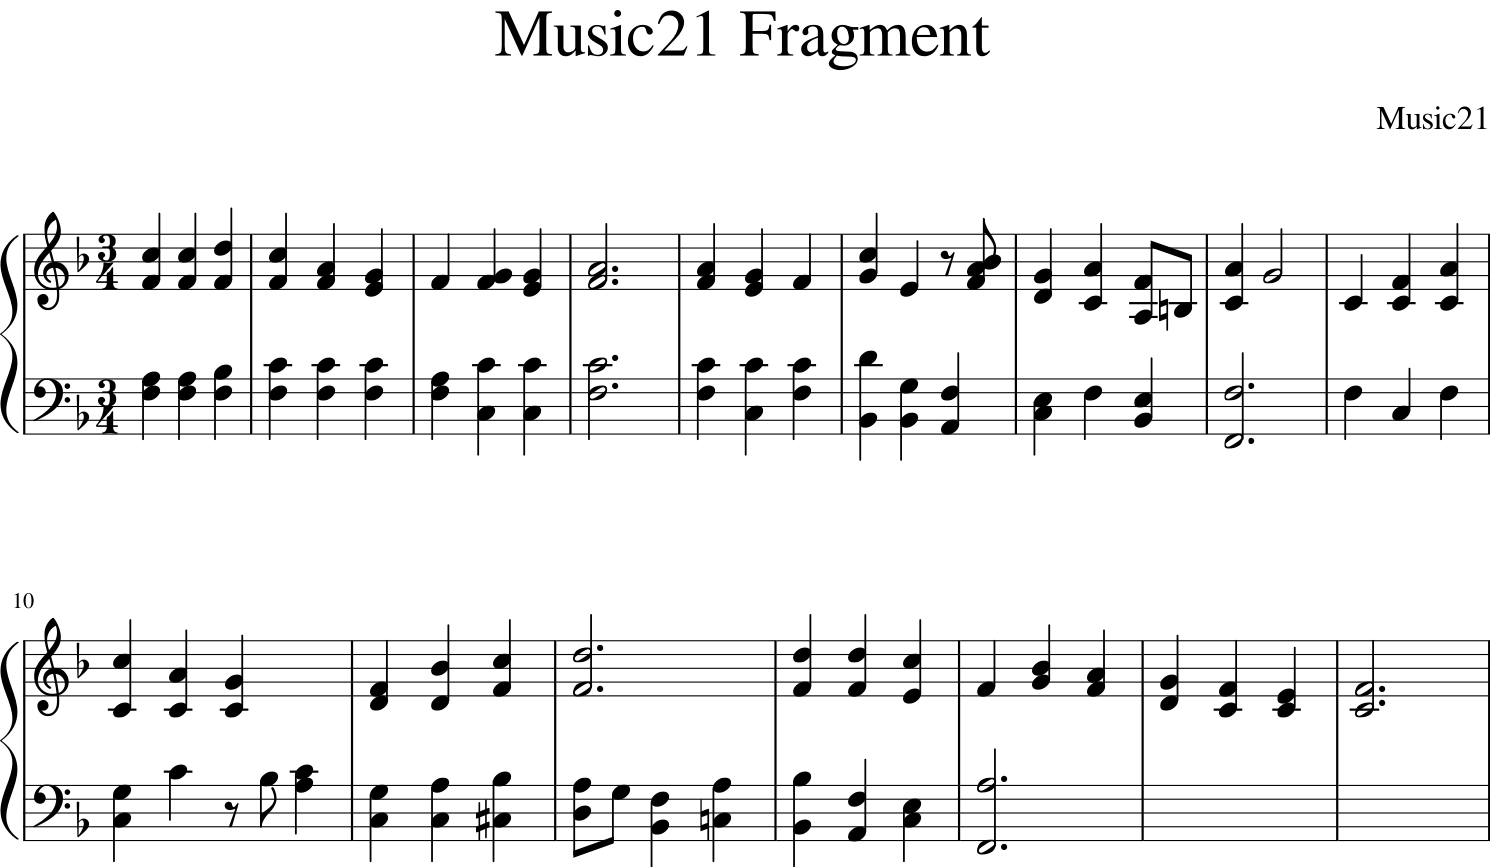

In [21]:
# Conversion en MusicXML + affichage
xml_path = "/content/output.musicxml"
score = convert_tokens_to_musicxml(tokens, xml_path)
display_and_play(xml_path)

J'ai generé une deuxieme fois avec les meme parametre pour voir si ca changeait beaucoup, et voici le résultat :

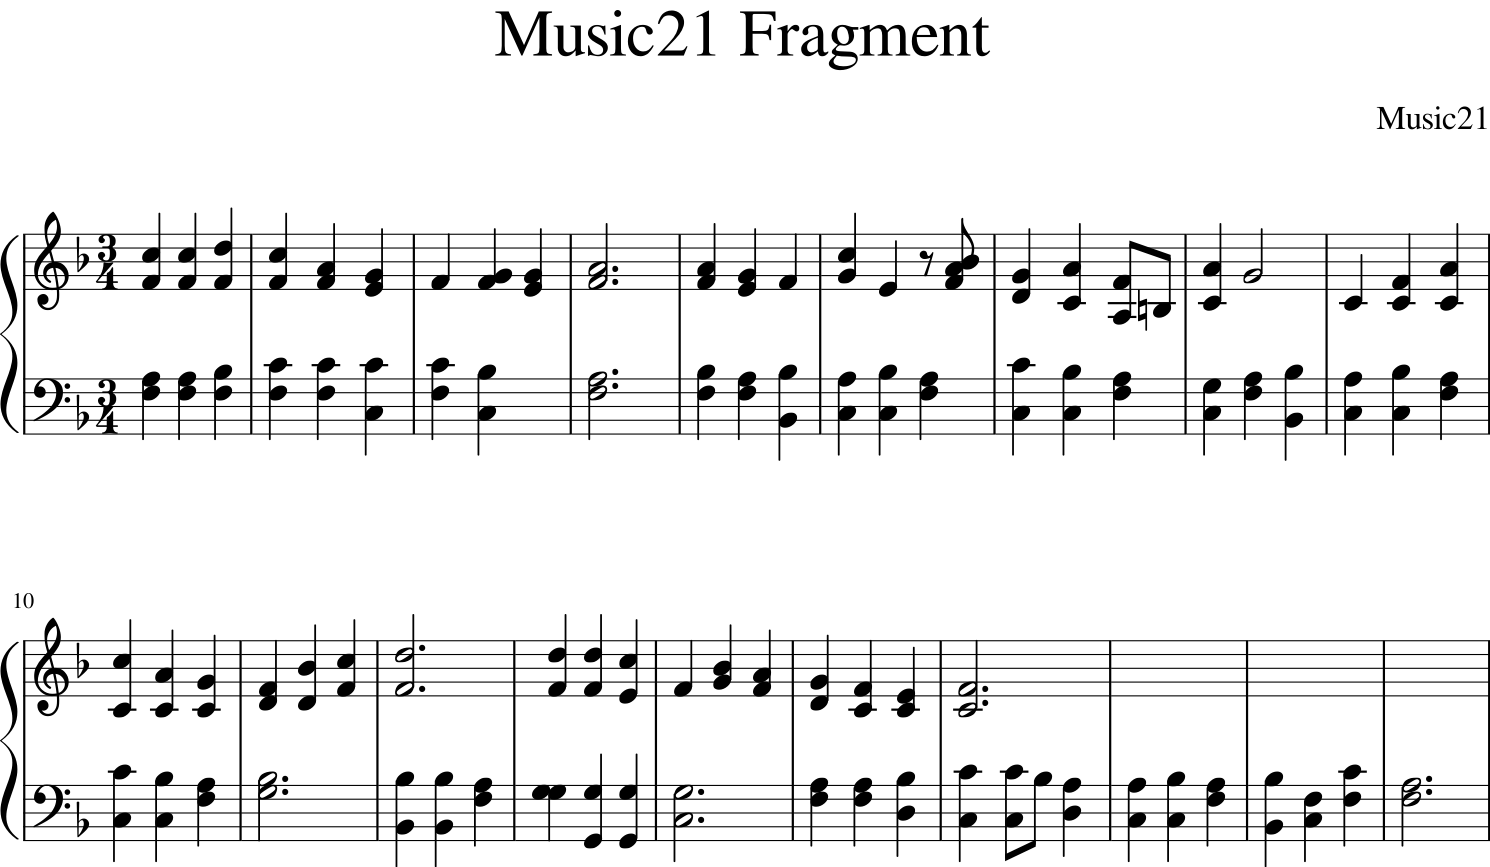

In [ ]:
display_and_play("/content/output.musicxml")

top_k=40

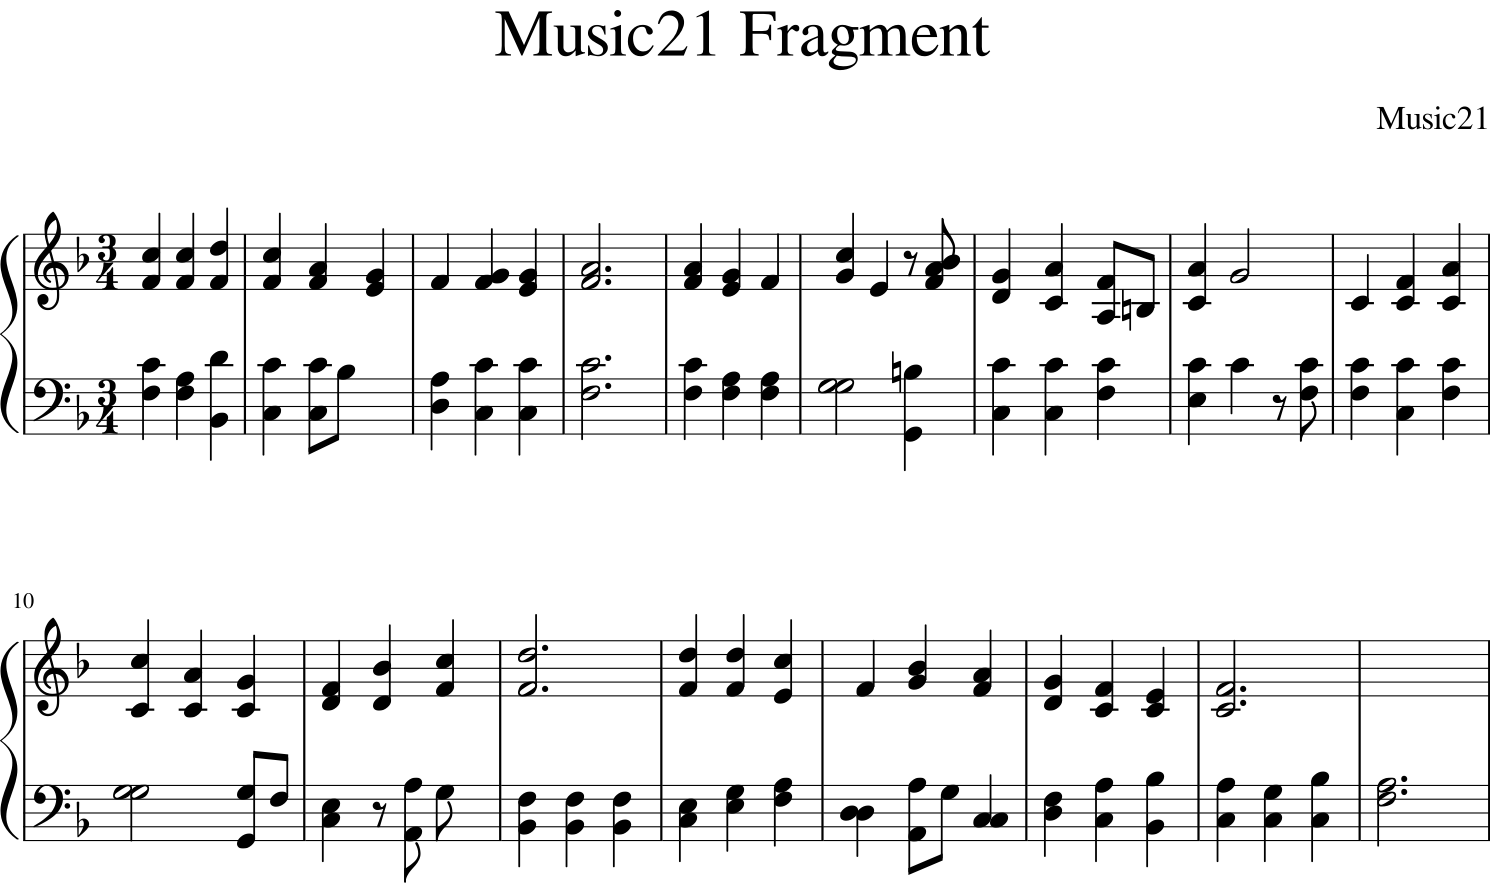

In [ ]:
display_and_play("/content/output.musicxml")

#### 4eme generation

In [ ]:
# chemin du fichier
partition_Bach = "/content/data/QmWtmdgRHpAfkEhet1VrX1ZDpqGFGMDCd8y2BsFzL3yAXj.txt"

# lire le contenu du fichier
with open(partition_Bach, "r") as f:
    content = f.read().strip()

# découper le contenu en tokens (séparés par des espaces)
tokens = content.split()

print(tokens[:50])  # afficher les 50 premiers pour vérifier
print(len(tokens), "tokens chargés")


['R', 'bar', 'key_natural_0', 'time_9/8', 'clef_treble', 'note_A5', 'len_1/2', 'note_E5', 'len_1/2', 'note_F5', 'len_1/2', 'note_A5', 'len_1/2', 'note_D5', 'len_1/2', 'note_E5', 'len_1/2', 'note_A5', 'len_1/2', 'note_C5', 'len_1/2', 'note_E5', 'len_1/2', 'bar', 'note_A5', 'len_1/2', 'note_B4', 'len_1/2', 'note_C5', 'len_1/2', 'note_A4', 'len_3/4', 'note_C5', 'len_1/4', 'note_B4', 'len_1/4', 'note_A4', 'len_1/4', 'note_D#5', 'len_1/2', 'note_C5', 'len_1/2', 'note_B4', 'len_1/2', 'bar', 'note_G5', 'len_1/2', 'note_D#5', 'len_1/2', 'note_E5']
670 tokens chargés


In [ ]:
partition_original = convert_tokens_to_musicxml(tokens,"partition_Bach.musicxml")

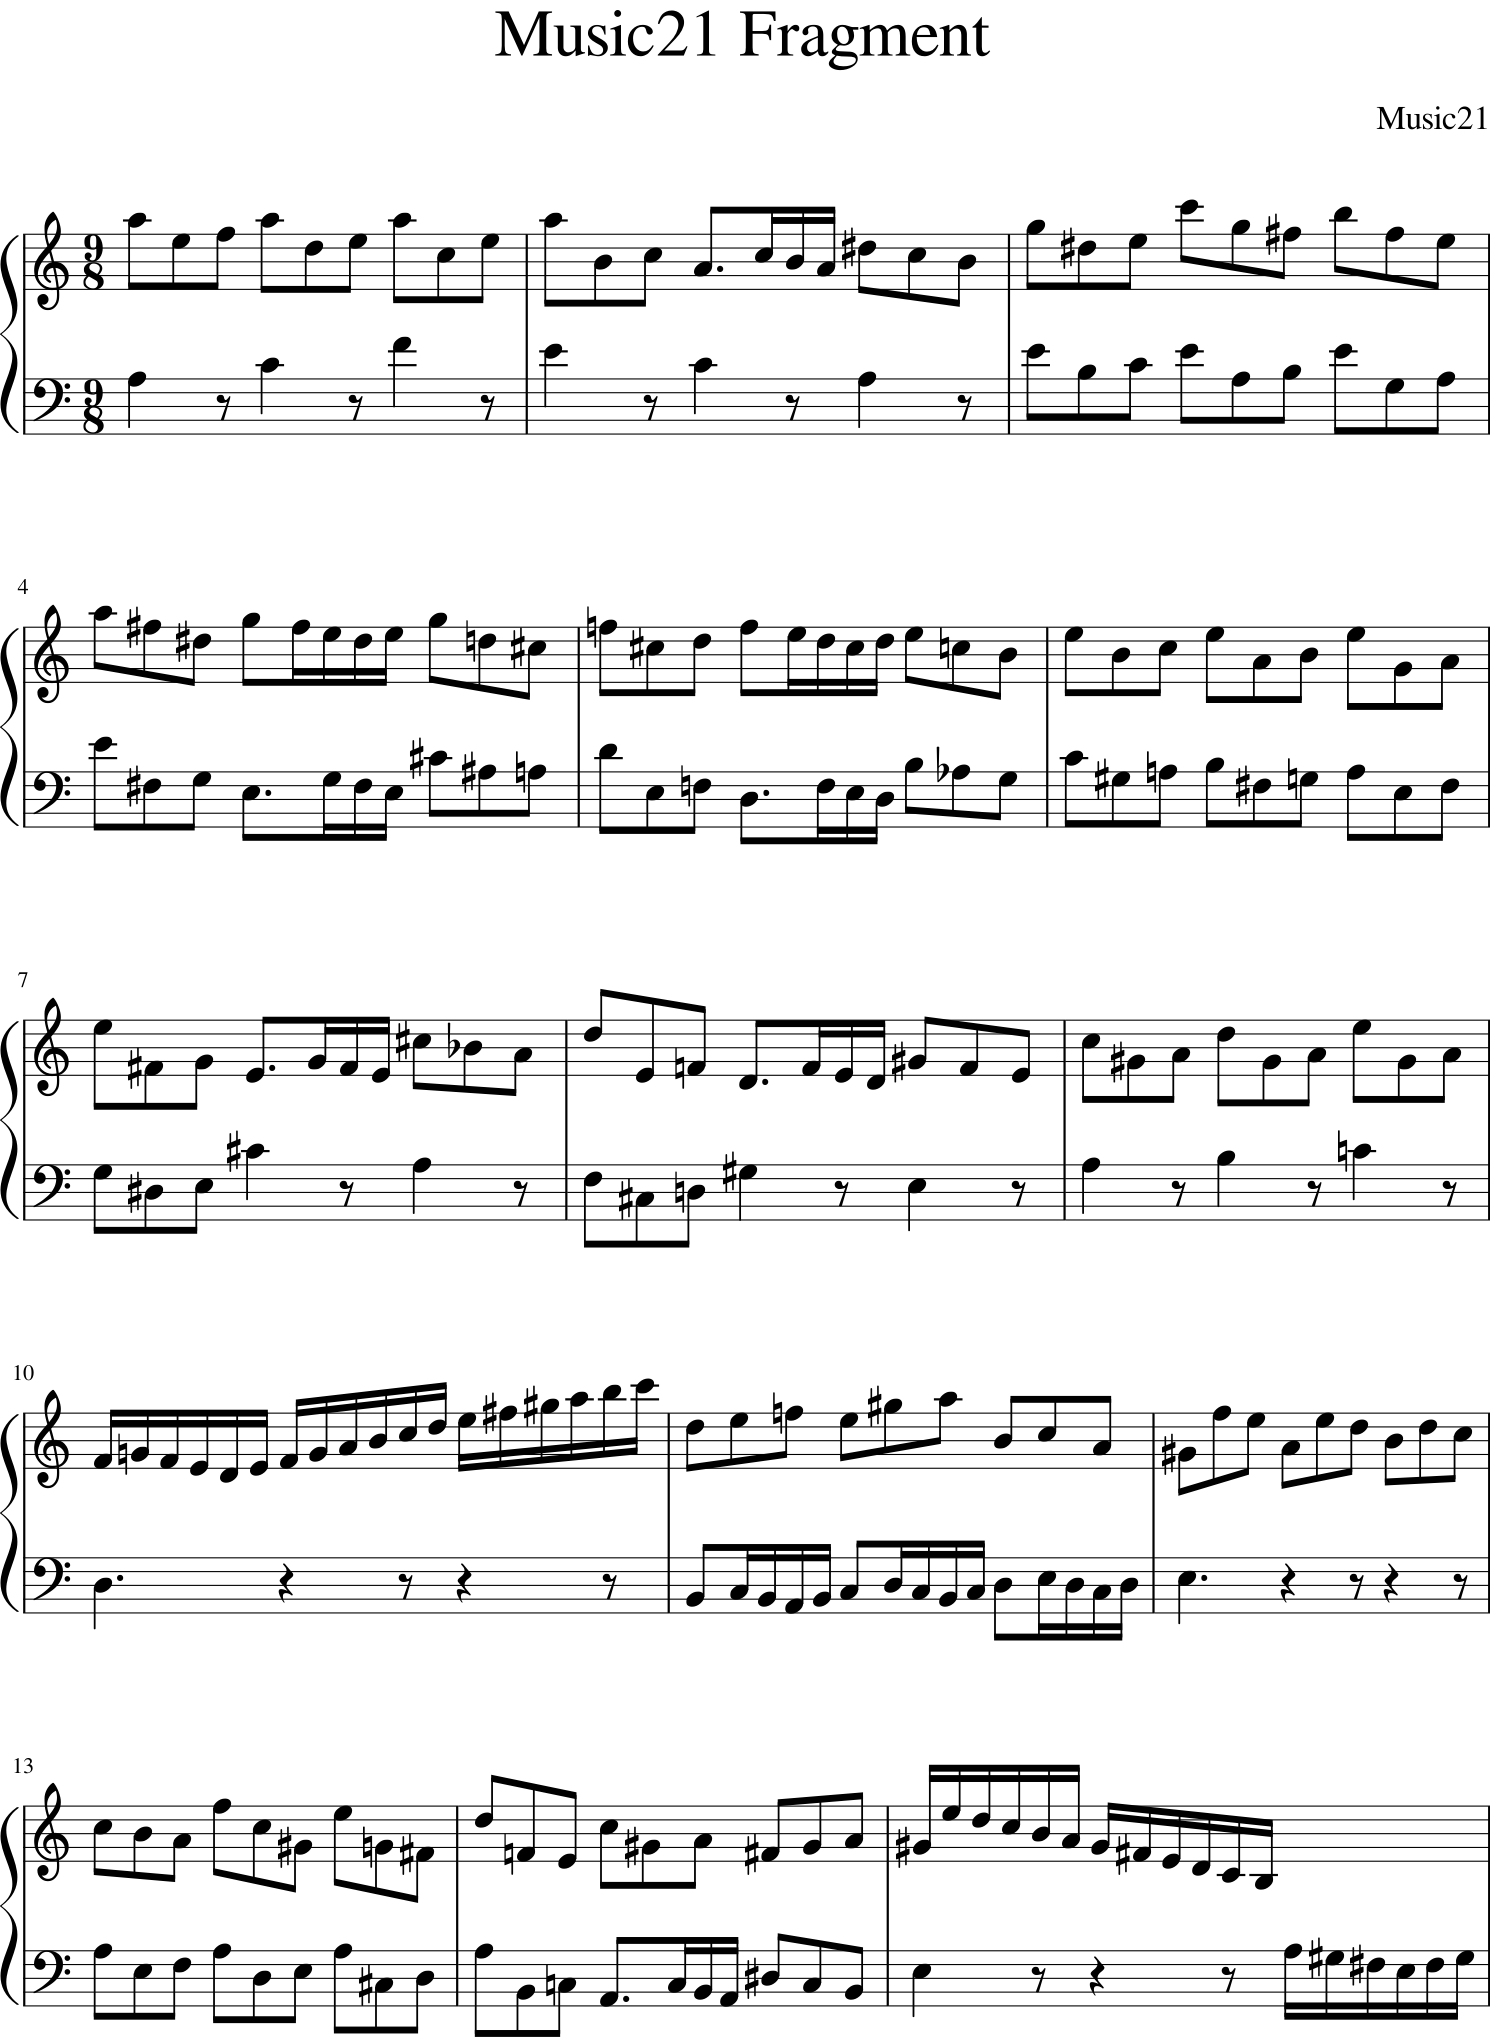

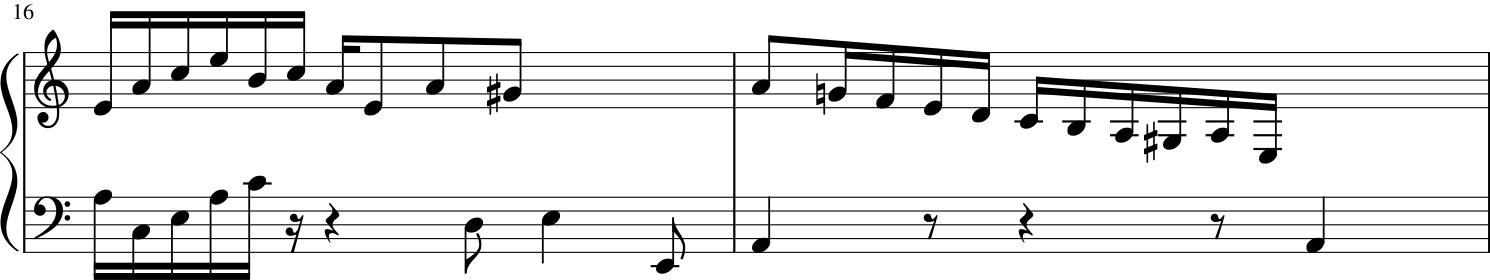

In [ ]:
display_and_play("/content/partition_Bach.musicxml")

In [30]:
from bachgen.generate import generate_tokens_from_primer
from pathlib import Path

MODEL_DIR  = "/content/drive/MyDrive/Stage MusicXML/Models_classical_piano/model_gpt2_ids_V2"
VOCAB_PATH = "/content/drive/MyDrive/Stage MusicXML/vocab_100%/token2id.json"

# ---------- 1) Prompt : début de main droite ----------
right_hand_beginning = [
    "R","bar","key_natural_0","time_9/8","clef_treble",
    "note_A5","len_1/2","note_E5","len_1/2","note_F5","len_1/2","note_A5","len_1/2","note_D5","len_1/2","note_E5","len_1/2","note_A5","len_1/2","note_C5","len_1/2","note_E5","len_1/2",
    "bar","note_A5","len_1/2","note_B4","len_1/2","note_C5","len_1/2","note_A4","len_3/4","note_C5","len_1/4","note_B4","len_1/4","note_A4","len_1/4","note_D#5","len_1/2","note_C5","len_1/2","note_B4","len_1/2",
    "bar"
]

# ---------- 2) Générer la main droite jusqu’à 'L' ----------
tokens_rh = generate_tokens_from_primer(
    model_dir=MODEL_DIR,
    vocab_path=VOCAB_PATH,
    primer_tokens=right_hand_beginning,
    stop_tokens={"L"},          # on s’arrête dès que 'L' est généré
    max_new_tokens=400,
    top_k=40,
    temperature=1.0,
)
print("→ RH générée (fin tronquée) :", tokens_rh[-40:])

# ---------- 3) Ajouter l’en-tête de la main gauche puis générer jusqu’à <EOS> ----------
lh_header = ["bar","key_natural_0","time_9/8","clef_bass"]
primer_lh = tokens_rh + lh_header

tokens_full = generate_tokens_from_primer(
    model_dir=MODEL_DIR,
    vocab_path=VOCAB_PATH,
    primer_tokens=primer_lh,
    stop_tokens=None,           # s’arrête uniquement sur <EOS> ou max_new_tokens
    max_new_tokens=400,
    top_k=40,
    temperature=1.0,
)
print("→ Séquence complète :", tokens_full)


→ RH générée (fin tronquée) : ['note_A5', 'len_1/2', 'bar', 'note_F#5', 'len_1/2', 'note_A5', 'len_1/2', 'note_E5', 'len_3/4', 'note_E5', 'len_1/4', 'note_A5', 'len_1/2', 'note_E3', 'len_1/2', 'note_A5', 'len_1/2', 'note_C6', 'len_1/2', 'bar', 'note_D5', 'len_1/2', 'note_G5', 'len_1/2', 'note_E5', 'len_1/2', 'bar', 'note_F#5', 'len_1/2', 'note_A5', 'len_1/2', 'note_D5', 'len_3/4', 'note_E5', 'len_1/4', 'note_D5', 'len_1', 'rest', 'len_1/2', 'L']
→ Séquence complète : ['R', 'bar', 'key_natural_0', 'time_9/8', 'clef_treble', 'note_A5', 'len_1/2', 'note_E5', 'len_1/2', 'note_F5', 'len_1/2', 'note_A5', 'len_1/2', 'note_D5', 'len_1/2', 'note_E5', 'len_1/2', 'note_A5', 'len_1/2', 'note_C5', 'len_1/2', 'note_E5', 'len_1/2', 'bar', 'note_A5', 'len_1/2', 'note_B4', 'len_1/2', 'note_C5', 'len_1/2', 'note_A4', 'len_3/4', 'note_C5', 'len_1/4', 'note_B4', 'len_1/4', 'note_A4', 'len_1/4', 'note_D#5', 'len_1/2', 'note_C5', 'len_1/2', 'note_B4', 'len_1/2', 'bar', 'note_C#5', 'len_1/2', 'note_D5', 'len

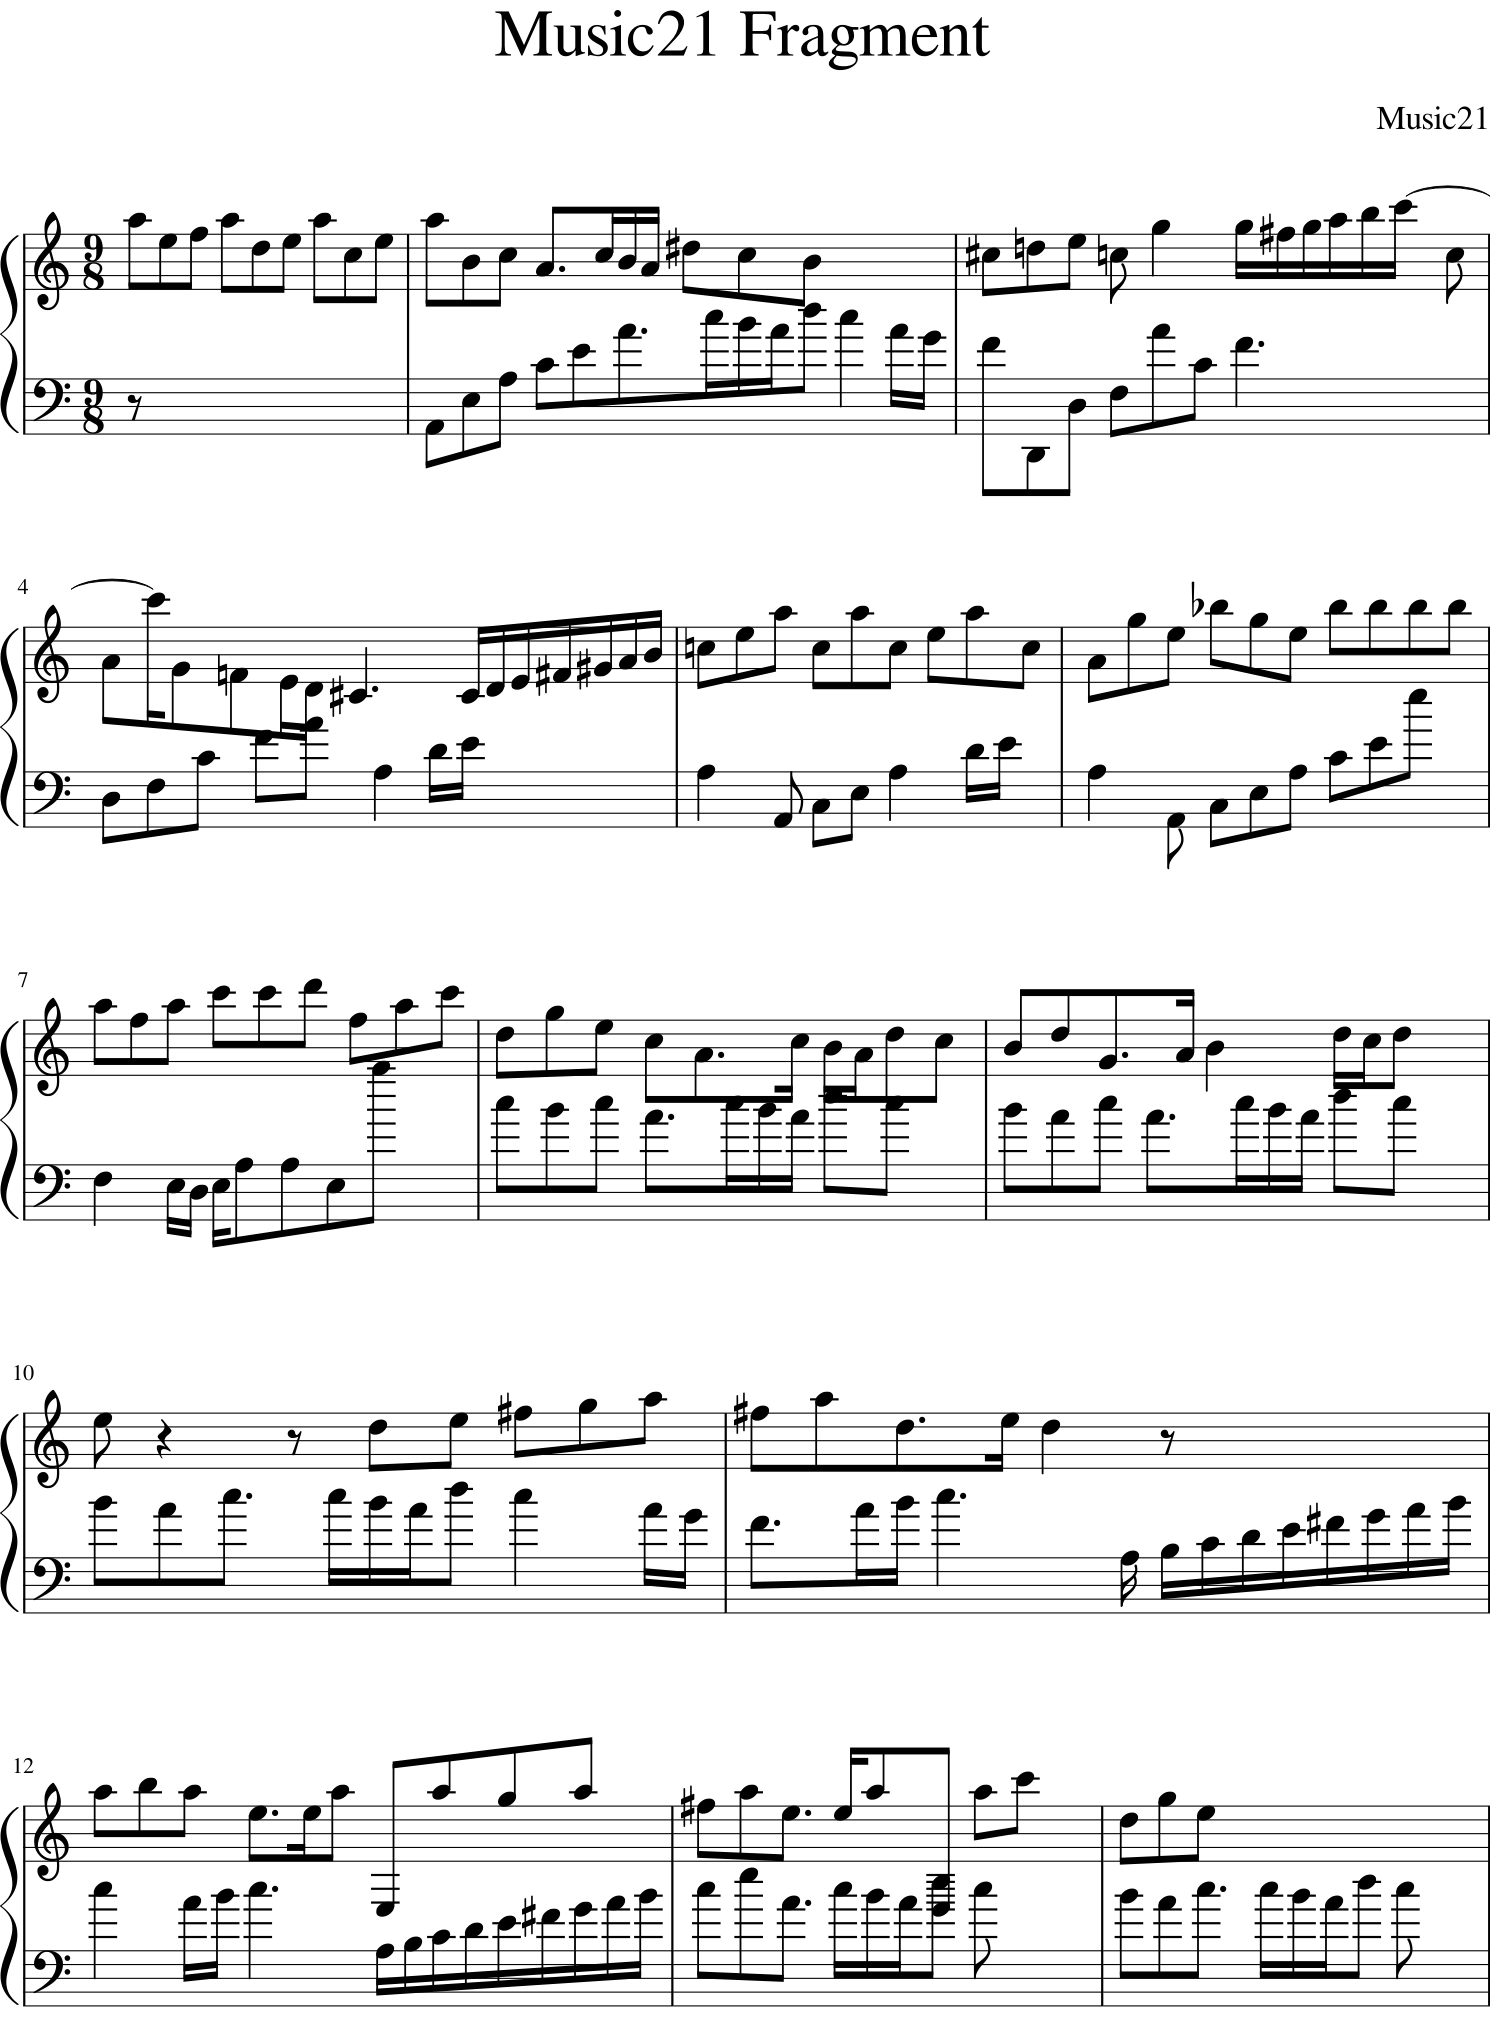

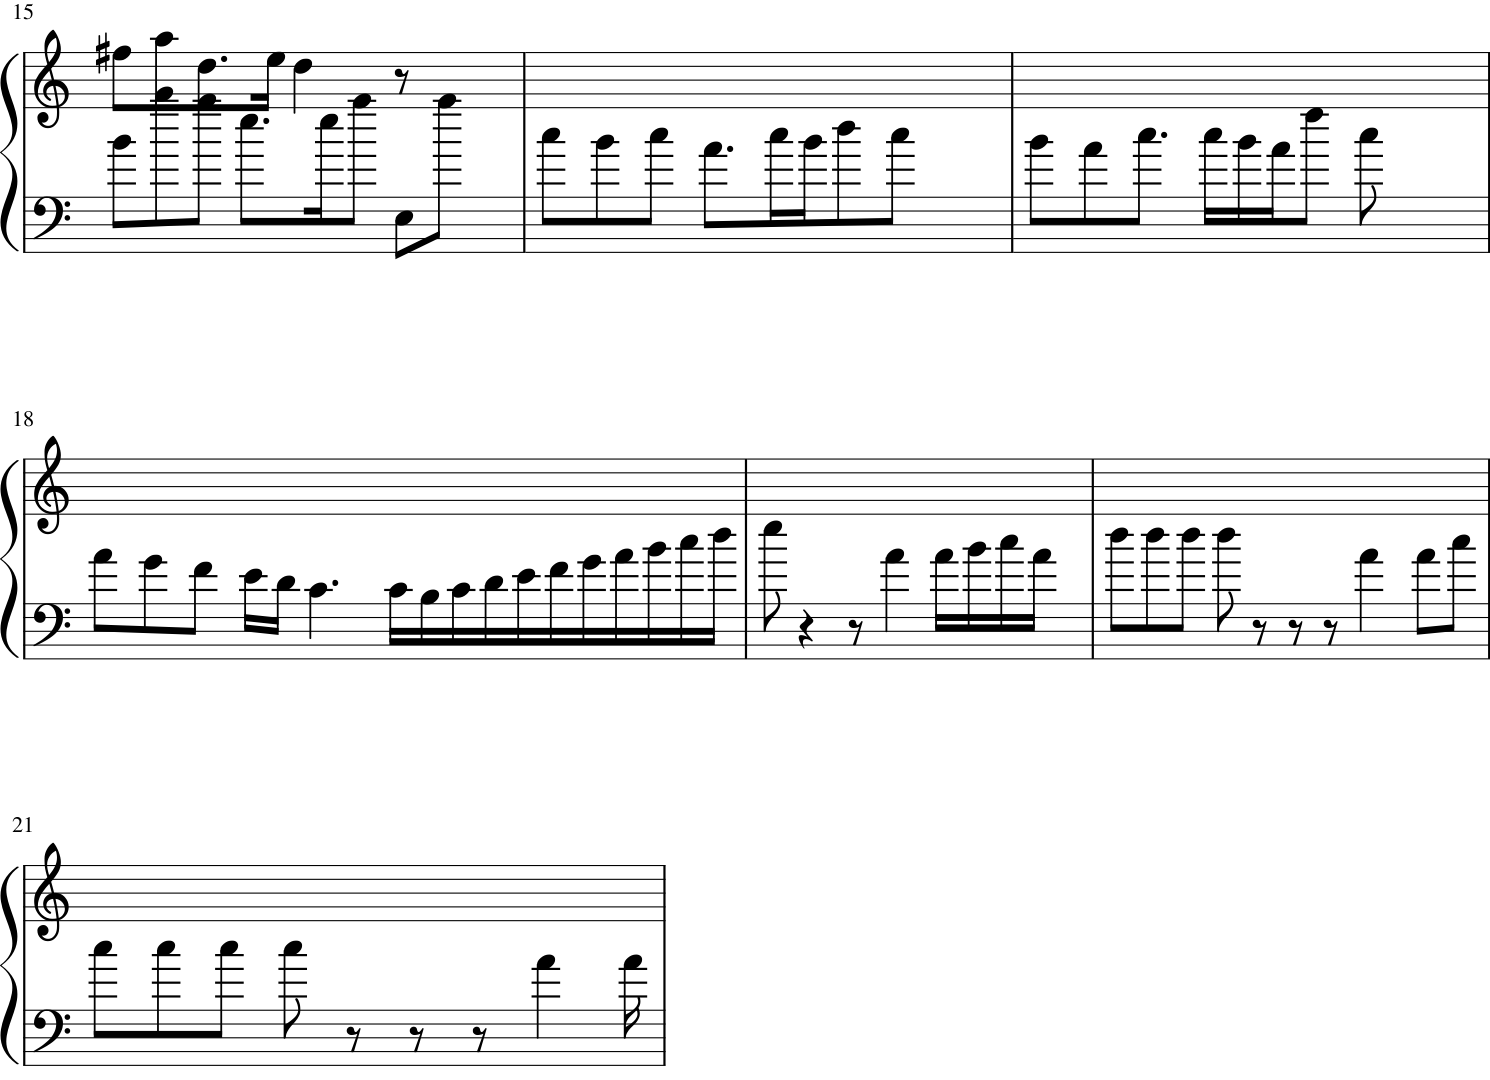

In [32]:
# Conversion en MusicXML + affichage
xml_path_full = "/content/output_full.musicxml"
score = convert_tokens_to_musicxml(tokens_full, xml_path_full)
display_and_play(xml_path_full)